In [1]:
import torch 
from torch import nn
import torchvision
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np 
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix
from tqdm import tqdm
import pandas as pd

In [2]:
class Config:
    def __init__(self):
        self.ROOD_DATA_DIR="ImageDir"
        self.EPOCH=30
        self.BATCH_SIZE=32
        self.LEARNING_RATE=0.01
        self.IMAGE_SIZE=(28,28)
        self.DEVICE="cuda" if torch.cuda.is_available() else "cpu"
        print(f"this notebook is using device: {self.DEVICE}")
        self.SEED=42
config=Config()

this notebook is using device: cpu


In [3]:
train_data=datasets.FashionMNIST(
    root=config.ROOD_DATA_DIR,
    train=True,
    download=True,
    transform=transforms.ToTensor()
)
test_data=datasets.FashionMNIST(
    root=config.ROOD_DATA_DIR,
    train=False,
    download=True,
    transform=transforms.ToTensor()

)

In [4]:
train_data.data.shape

torch.Size([60000, 28, 28])

In [5]:
test_data.data.shape

torch.Size([10000, 28, 28])

In [6]:
train_data.class_to_idx

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

In [9]:
train_data.targets

tensor([9, 0, 0,  ..., 3, 0, 5])

In [10]:
given_lavel_map=train_data.class_to_idx
given_lavel_map

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

In [11]:
lavel_map={key:val for key, val in given_lavel_map.items()}
lavel_map

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

In [12]:
label_map={val:key for key, val in given_lavel_map.items()}
label_map

{0: 'T-shirt/top',
 1: 'Trouser',
 2: 'Pullover',
 3: 'Dress',
 4: 'Coat',
 5: 'Sandal',
 6: 'Shirt',
 7: 'Sneaker',
 8: 'Bag',
 9: 'Ankle boot'}

In [13]:
train_data.targets[0].item()

9

(-0.5, 27.5, 27.5, -0.5)

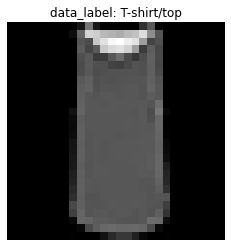

In [14]:
idx=2
plt.imshow(train_data.data[idx], cmap="gray")

plt.title(f"data_label: {label_map[train_data.targets[idx].item()]}")
plt.axis("off")


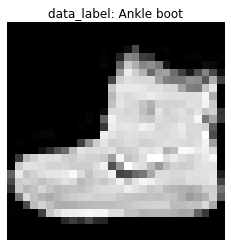

In [15]:
def view_sample_img(data, idx, label_map):
    plt.imshow(data.data[idx], cmap="gray")
    plt.title(f"data_label: {label_map[data.targets[idx].item()]}")
    plt.axis("off")
view_sample_img(train_data, 0, label_map)

# Create data loader

In [16]:
train_data_loader=DataLoader(
    dataset=train_data,
    batch_size=config.BATCH_SIZE,
    shuffle=True
)
test_data_loader=DataLoader(
    dataset=test_data,
    batch_size=config.BATCH_SIZE,
    shuffle=False
)

In [17]:
for images, labels in train_data_loader:
    print(images.shape)
    print(labels.shape)
    break

torch.Size([32, 1, 28, 28])
torch.Size([32])


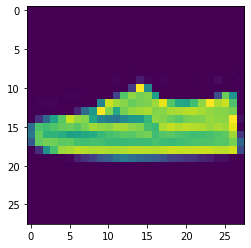

In [18]:
plt.imshow(images[0].permute(1,2,0))

In [19]:
images[0].shape

torch.Size([1, 28, 28])

In [20]:
images[0].squeeze().shape

torch.Size([28, 28])

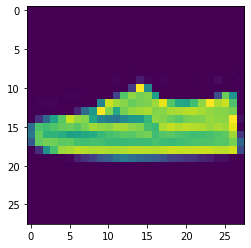

In [21]:
plt.imshow(images[0].squeeze().numpy())

# Define CNN Architecture

In [22]:
class CNN(nn.Module):
    def __init__(self, in_, out_):
        super(CNN, self).__init__()
        self.conv_pool_01=nn.Sequential(
            nn.Conv2d(in_channels=in_, out_channels=8, kernel_size=5, stride=1, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.conv_pool_02=nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=5, stride=1, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.Flatten=nn.Flatten()
        self.FC_01=nn.Linear(in_features=16*4*4, out_features=128)
        self.FC_02=nn.Linear(in_features=128, out_features=64)
        self.FC_03=nn.Linear(in_features=64, out_features=out_)
                                        
    def forward(self,x):
        x=self.conv_pool_01(x)
        x=self.conv_pool_02(x)
        x=self.Flatten(x)
        x=F.relu(x)
        x=self.FC_01(x)
        x=F.relu(x)
        x=self.FC_02(x)
        x=F.relu(x)
        x=self.FC_03(x)
        x=F.relu(x)
        return x

In [23]:
model=CNN(1,10)
print(model)

CNN(
  (conv_pool_01): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_pool_02): Sequential(
    (0): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (Flatten): Flatten(start_dim=1, end_dim=-1)
  (FC_01): Linear(in_features=256, out_features=128, bias=True)
  (FC_02): Linear(in_features=128, out_features=64, bias=True)
  (FC_03): Linear(in_features=64, out_features=10, bias=True)
)


In [24]:
model.conv_pool_01

Sequential(
  (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)

In [25]:
model.FC_03

Linear(in_features=64, out_features=10, bias=True)

In [26]:
model.to(config.DEVICE)

CNN(
  (conv_pool_01): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_pool_02): Sequential(
    (0): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (Flatten): Flatten(start_dim=1, end_dim=-1)
  (FC_01): Linear(in_features=256, out_features=128, bias=True)
  (FC_02): Linear(in_features=128, out_features=64, bias=True)
  (FC_03): Linear(in_features=64, out_features=10, bias=True)
)

next(model.parameters()).is_cuda

# Count the number of parameters

In [31]:
def count_params(model):
    model_params={"Modules":list(),"Parameters":list()}
    total=0
    for name, parameters in model.named_parameters():
        if not parameters.requires_grad:
            continue
        param=parameters.numel()
        model_params["Modules"].append(name)  
        model_params["Parameters"].append(param)
        total +=param
    df=pd.DataFrame(model_params)
    df=df.style.set_caption(f"Total trainable parameters: {total}")
    return df
count_params(model)
        

,Modules,Parameters
0,conv_pool_01.0.weight,200
1,conv_pool_01.0.bias,8
2,conv_pool_02.0.weight,3200
3,conv_pool_02.0.bias,16
4,FC_01.weight,32768
5,FC_01.bias,128
6,FC_02.weight,8192
7,FC_02.bias,64
8,FC_03.weight,640
9,FC_03.bias,10
